### Code block 1: Package initialization
Import required packages, do not change.

In [1]:
import argparse
import os, sys
import time
import datetime
import math
import numpy as np
import matplotlib.pyplot as plt

# Import pytorch dependencies
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.modules.utils import _single, _pair, _triple


### Code block 2: Useful classes
Customized implementation of [nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) and [nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear), do not change.

In [2]:
class CONV(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1,
                 bias=False, padding_mode='zeros'):
        self.input = None
        self.output = None
        kernel_size = _pair(kernel_size)
        stride = _pair(stride)
        padding = _pair(padding)
        dilation = _pair(dilation)
        super(CONV, self).__init__(
            in_channels, out_channels, kernel_size, stride, padding, dilation, 
            groups, bias, padding_mode)
    
    def forward(self, input):
        self.input = input
        if '1.5' in torch.__version__:
            self.output = self._conv_forward(input, self.weight) #1.5
        elif '1.4' in torch.__version__:
            self.output = self.conv2d_forward(input, self.weight) #1.4
        return self.output
    
class FC(nn.Linear):
    def __init__(self, in_features, out_features, bias=True):
        self.input = None
        self.output = None
        super(FC, self).__init__(in_features, out_features, bias)
    
    def forward(self, input):
        self.input = input
        self.output = F.linear(input, self.weight, self.bias)
        return self.output

## Lab 2

### Code block 3: LeNet-5 implementation

Please follow the instructions in Lab 2(a) and fill in the code in the lines marked **Your code here**

In [3]:
""" 
Lab 2(a)
Build the LeNet-5 model by following Table 1
"""

# Create the neural network module: LeNet-5
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        # Layer definition
        self.conv1 =     CONV(in_channels=3, out_channels=6, kernel_size=5, stride=1)
        self.conv2 =     CONV(in_channels=6, out_channels=16, kernel_size=5, stride=1)
        self.fc1   =     FC(in_features = 400, out_features = 120)
        self.fc2   =     FC(120, 84)
        self.fc3   =     FC(84, 10)
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.relu = nn.ReLU()

    def forward(self, x):
        # Forward pass computation
        # Conv 1
        x = self.conv1(x)
        x = self.relu(x)
        # MaxPool
        x = self.maxpool(x)
        # Conv 2
        x = self.conv2(x)
        x = self.relu(x)
        # MaxPool
        x = self.maxpool(x)
        # Flatten
        x = x.view(x.size(0), -1)
        # FC 1
        x = self.fc1(x)
        x = self.relu(x)
        # FC 2
        x = self.fc2(x)
        x = self.relu(x)
        # FC 3
        out = self.fc3(x)
        return out

# GPU check                
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device =='cuda':
    print("Run on GPU...")
else:
    print("Run on CPU...")

# Model Definition  
net = LeNet5()
net = net.to(device)

# Test forward pass
data = torch.randn(5,3,32,32)
data = data.to(device)
# Forward pass "data" through "net" to get output "out" 
out = net(data)    #Your code here

# Check output shape
assert(out.detach().cpu().numpy().shape == (5,10))
print("Forward pass successful")

Run on GPU...
Forward pass successful


### Code block 4: Shape observation
Please follow the instructions in Lab 2(a) and fill in the code in the lines marked **Your code here**. Gather the printed results in Table 2 in your report.

In [10]:
"""
Lab 2(b)
"""
# Forward pass of a single image
data = torch.randn(1,3,32,32).to(device)
# Forward pass "data" through "net" to get output "out" 
out = net(data)

# Iterate through all the CONV and FC layers of the model
for name, module in net.named_modules():
    if isinstance(module, CONV) or isinstance(module, FC):
        # Get the input feature map of the module as a NumPy array
        input = module.input.cpu().detach().numpy()
        # Get the output feature map of the module as a NumPy array
        output = module.output.cpu().detach().numpy()
        # Get the weight of the module as a NumPy array
        weight = module.weight.cpu().detach().numpy()
        # Compute the number of parameters in the weight
        num_Param = np.product(weight.shape)
        # Compute the number of MACs in the layer
        if isinstance(module, CONV):
            num_MAC = num_Param*output.shape[-2]**2
        else:
            num_MAC = num_Param
        
        print(f'{name:10} {str(input.shape):20} {str(output.shape):20} {str(weight.shape):20} {str(num_Param):10} {str(num_MAC):10}')


conv1      (1, 3, 32, 32)       (1, 6, 28, 28)       (6, 3, 5, 5)         450        352800    
conv2      (1, 6, 14, 14)       (1, 16, 10, 10)      (16, 6, 5, 5)        2400       240000    
fc1        (1, 400)             (1, 120)             (120, 400)           48000      48000     
fc2        (1, 120)             (1, 84)              (84, 120)            10080      10080     
fc3        (1, 84)              (1, 10)              (10, 84)             840        840       


## Lab 3 (Bonus)

### Code block 5: Initial weight histogram
Please follow the instructions in Lab 3(a) and fill in the code in the lines marked **Your code here**. Copy the output figures into your report.

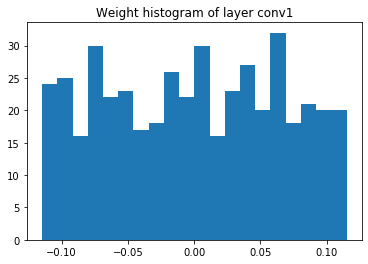

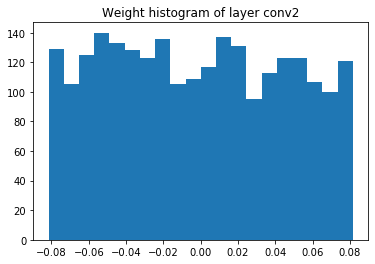

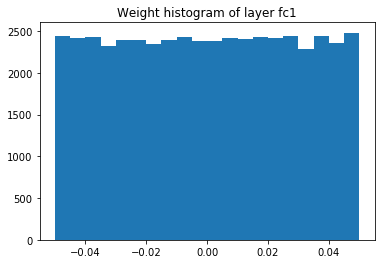

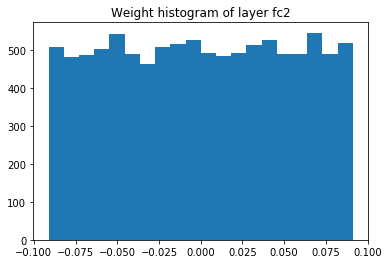

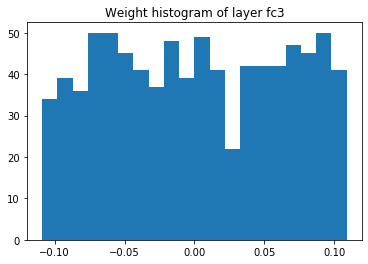

In [14]:
"""
Lab 3(a)
"""
for name, module in net.named_modules():
    if isinstance(module, CONV) or isinstance(module, FC):
        # Get the weight of the module as a NumPy array
        weight = module.weight.cpu().detach().numpy()
        
        # Reshape for histogram
        weight = weight.reshape(-1)
        _ = plt.hist(weight, bins=20)
        plt.title("Weight histogram of layer "+name)
        plt.show()

### Code block 6: Gradient histogram
Please follow the instructions in Lab 3(b) and fill in the code in the lines marked **Your code here**. Copy the output figures into your report.

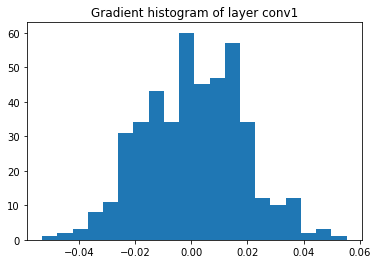

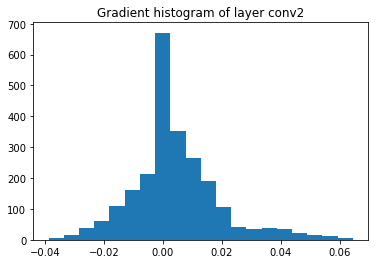

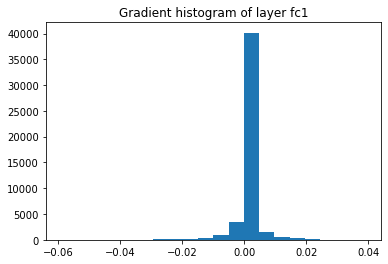

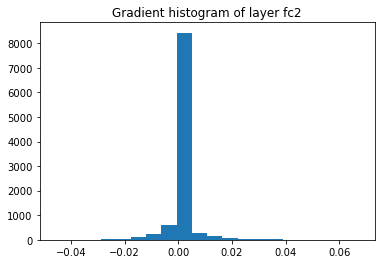

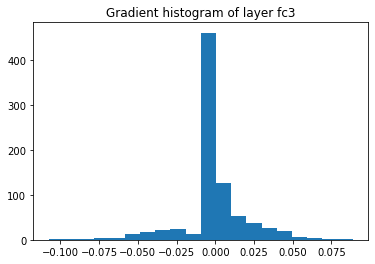

In [18]:
'''
Lab 3(b)
'''
# Loss definition
criterion = nn.MSELoss()
# Random target
target = torch.randn(1, 10).to(device)

# Loss computation
loss = criterion(out, target)
# Backward pass for gradients
loss.backward()


for name, module in net.named_modules():
    if isinstance(module, CONV) or isinstance(module, FC):
        # Get the gradient of the module as a NumPy array
        gradient = module.weight.grad.detach().cpu().numpy()
        
        # Reshape for histogram
        gradient = gradient.reshape(-1)
        _ = plt.hist(gradient, bins=20)
        plt.title("Gradient histogram of layer "+name)
        plt.show()


### Code block 7: Zero initialization?
Please follow the instructions in Lab 3(c) and fill in the code in the lines marked **Your code here**. Copy the output figures into your report.

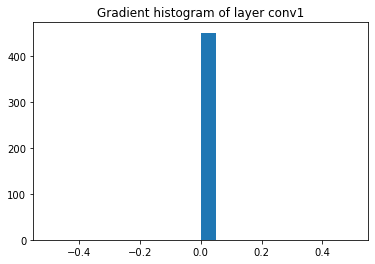

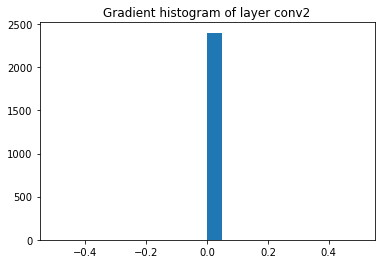

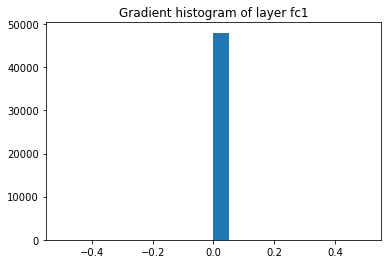

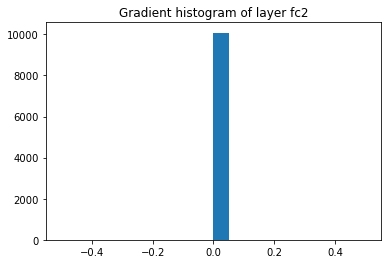

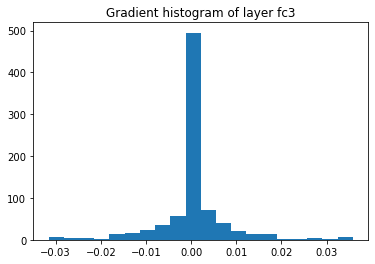

In [42]:
'''
Lab 3(c)
'''
# Set model weights to zero
for name, module in net.named_modules():
    if isinstance(module, CONV) or isinstance(module, FC):
        # Set the weight of each module to all zero
        module.weight.data.new_zeros(module.weight.data.shape[0])

# Reset gradients
net.zero_grad()
        
# Forward and backward pass
# Random data and target
data = torch.randn(1,3,32,32).to(device)
target = torch.randn(1, 10).to(device)

# Forward pass
out = net(data)
# Loss computation
loss = criterion(out, target)
# Backward pass
loss.backward()

for name, module in net.named_modules():
    if isinstance(module, CONV) or isinstance(module, FC):
        # Get the gradient of the module as a NumPy arraya
        gradient = module.weight.grad.detach().cpu().numpy()
        
        # Reshape for histogram
        gradient = gradient.reshape(-1)
        _ = plt.hist(gradient, bins=20)
        plt.title("Gradient histogram of layer "+name)
        plt.show()